In [7]:
from typing import Annotated, TypedDict, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json

In [8]:

load_dotenv()

True

In [9]:
search_tool = TavilySearchResults(max_results=4)
tools = [search_tool]
model = ChatGroq(model = "llama3-8b-8192").bind_tools(tools=tools)
memory = MemorySaver()

In [10]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model_node(state: State):
    result = await model.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return "end"
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model_node", model_node)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model_node")

graph_builder.add_conditional_edges("model_node", tools_router,{
    "tool_node":"tool_node",
    "end":END
})
graph_builder.add_edge("tool_node", "model_node")

graph = graph_builder.compile(checkpointer=memory)

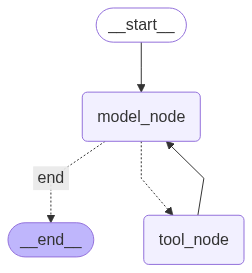

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [18]:
config = {
    "configurable": {
        "thread_id": 7
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config):
    if event["event"]=="on_chat_model_stream":
        print(event["data"]["chunk"].content,end="",flush=True)
    # print(event)

APR 03 or Fri May 30, 2025, or Tuesday, June 10, 2025.